In [36]:
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import transform
import keras
from collections import deque
from IPython import display
import imageio
from skimage.transform import resize
import os

In [37]:
env = gym.make('BreakoutDeterministic-v4')
frame = env.reset()

# Initialize parameters

frame_height = 84
frame_width = 84
state_size = [frame_height, frame_width, 4]
action_size = env.action_space.n
learning_rate = 0.000035
discount_rate = 0.99

eps_start = 1
eps_end1 = 0.1
eps_end2 = 0.01
frame_start1 = 1 * 1000
frame_end1 = 50 * 1000

batch_size = 32
episodes_num = 0
max_steps = 0
max_frames = 2 * 1000 * 1000
max_frames_per_ep = 18 * 1000

experience_size = 8 * 1000

stack_size = 4

no_op_steps = 10

update_network_freq = 1000



RUN_NUM = 7
PATH = 'results'
SUMMARIES = 'summaries'
RUN_ID = 'run_' + str(RUN_NUM)
PATH = os.path.join(PATH, RUN_ID)
os.makedirs(PATH, exist_ok=True)
os.makedirs(os.path.join(SUMMARIES, RUN_ID), exist_ok=True)

Box(210, 160, 3)
4


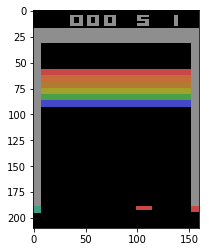

In [38]:
print(env.observation_space)
print(env.action_space.n)
plt.imshow(frame)
plt.show()

In [39]:
def process(frame):
    gray = rgb2gray(frame)
    crop = gray[4:-15,5:-5]
    norm = crop / 255.0
    transformed = transform.resize(norm, [frame_height, frame_width, 1])
    return transformed

In [40]:
class Qnetwork:
    def __init__(self, state_size, action_size, learning_rate, name='Qnetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            self.input = tf.placeholder(dtype=tf.float32, shape=[None, *self.state_size], name='input')
            self.target_Q = tf.placeholder(dtype=tf.float32, shape=[None], name='target')
            
            self.conv1 = tf.layers.conv2d(
                inputs=self.input, filters=32, kernel_size=8, strides=4,
                kernel_initializer=tf.variance_scaling_initializer(scale=2), padding='VALID', 
                activation=tf.nn.relu, use_bias=False, name='conv1')
            
            self.conv2 = tf.layers.conv2d(
                inputs=self.conv1, filters=64, kernel_size=4, strides=2,
                kernel_initializer=tf.variance_scaling_initializer(scale=2), padding='VALID', 
                activation=tf.nn.relu, use_bias=False, name='conv2')
            
            self.conv3 = tf.layers.conv2d(
                inputs=self.conv2, filters=64, kernel_size=3, strides=1,
                kernel_initializer=tf.variance_scaling_initializer(scale=2), padding='VALID', 
                activation=tf.nn.relu, use_bias=False, name='conv3')
            
            
            self.flatten = tf.contrib.layers.flatten(self.conv3)
            
            self.ful_con1 = tf.layers.dense(inputs=self.flatten, units=512, 
                                    activation=tf.nn.relu, name='ful_con1')
            
            self.ful_con2 = tf.layers.dense(inputs=self.ful_con1, units=128, 
                                    activation=tf.nn.relu, name='ful_con2')
            
            self.output = tf.layers.dense(inputs=self.ful_con2, units=self.action_size, activation=None)
            
            self.best_action = tf.argmax(self.output, axis=-1)
            
            self.action = tf.placeholder(shape=[None], dtype=tf.int32)
            self.predicted_Q = tf.reduce_sum(tf.multiply(self.output, tf.one_hot(self.action, action_size, dtype=tf.float32)), axis=1)
            
            self.loss = tf.reduce_mean(tf.losses.huber_loss(labels=self.target_Q, predictions=self.predicted_Q))
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            self.update = self.optimizer.minimize(self.loss)

In [41]:
class ExperienceBuffer:
    def __init__(self, size, frame_height, frame_width, stack_size, batch_size):
        self.size = size
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.stack_size = stack_size
        self.batch_size = batch_size
        self.now_size = 0
        self.now_pos = 0
        self.actions = np.zeros(self.size, dtype=np.uint8)
        self.frames = np.zeros((self.size, frame_height, frame_width), dtype=np.uint8)
        self.rewards = np.zeros(self.size, dtype=np.float32)
        self.end_life = np.zeros(self.size, dtype=np.bool)
        
        self.states = np.zeros((self.batch_size, self.stack_size, frame_height, 
                                frame_width), dtype=np.uint8)
        self.next_states = np.zeros((self.batch_size, self.stack_size, frame_height, 
                                     frame_width), dtype=np.uint8)
        self.indices = np.zeros(self.batch_size, dtype=np.int32)
        
    def add(self, action, frame, reward, end_life):
        self.actions[self.now_pos] = action
        self.frames[self.now_pos, ...] = frame
        self.rewards[self.now_pos] = reward
        self.end_life[self.now_pos] = end_life
        self.now_pos = (self.now_pos + 1) % self.size
        self.now_size = max(self.now_size, self.now_pos)
        
    def get_indices(self):
        # do not accept frames from different life spans
        for i in range(self.batch_size):
            while True:
                index = np.random.randint(self.stack_size, self.now_size)
                if self.end_life[index - self.stack_size:index].any():
                    continue
                if index < self.stack_size + 1:
                    continue
                if index >= self.now_pos and (index - self.stack_size) <= self.now_pos:
                    continue
                break
            self.indices[i] = index
    
    def get_batch(self):
        self.get_indices()
        for i, j in enumerate(self.indices):
            self.states[i] = self.frames[j - 1 - self.stack_size:j - 1, ...]
            self.next_states[i] = self.frames[j - self.stack_size:j, ...]
        return np.transpose(self.states, axes=(0, 2, 3, 1)), self.actions[self.indices], self.rewards[self.indices], np.transpose(self.next_states, axes=(0, 2, 3, 1)), self.end_life[self.indices]

In [42]:
def get_eps(count_frames, test):
    eps = 0
    if test:
        eps = 0
    elif count_frames < frame_start1:
        eps = eps_start
    elif count_frames >= frame_start1 and count_frames < frame_end1:
        eps = ((count_frames - frame_start1) * (eps_end1 - eps_start)) / (frame_end1 - frame_start1) + eps_start
    else:
        eps = eps_end1
    return eps

def get_action(sess, count_frames, state, network, test):
    eps = get_eps(count_frames, test)
    
    if np.random.rand(1) < eps:
        return (np.random.randint(0, action_size), eps)
    return (sess.run(network.best_action, feed_dict={network.input : 
                                                    state.reshape((1, *state.shape))}), eps)
        

In [43]:
def env_reset(env, lives_left, test=False):
    frame = env.reset()
    lives_left = 0
    if_life_lost = True
    
    if test:
        for i in range(np.random.randint(1, no_op_steps)):
            frame, _, _, _ = env.step(1)
    
    processed_frame = process(frame)
    state = np.repeat(processed_frame, stack_size, axis=2)
    return state, if_life_lost

def env_step(env, action, lives_left, state):
    next_frame, reward, done, info = env.step(action)
    if info['ale.lives'] < lives_left:
        if_life_lost = True
    else:
        if_life_lost = done
    lives_left = info['ale.lives']
    
    processed_next_frame = process(next_frame)
    next_state = np.append(state[:, :, 1:], processed_next_frame, axis=2)
    return next_state, reward, done, lives_left, if_life_lost, processed_next_frame, next_frame

In [44]:
def update_network_variables(sess, network_vars, target_network_vars):
    assigns = []
    for w_agent, w_target in zip(network_vars, target_network_vars):
        assigns.append(tf.assign(w_target, w_agent))
    
    sess.run(assigns)

In [45]:
tf.reset_default_graph()

with tf.variable_scope('network'):
    network = Qnetwork(state_size, action_size, learning_rate)
    
with tf.variable_scope('target_network'):
    target_network = Qnetwork(state_size, action_size, learning_rate)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
WRITER = tf.summary.FileWriter(os.path.join(SUMMARIES, RUN_ID))

network_variables = tf.trainable_variables(scope='network')
target_network_variables = tf.trainable_variables(scope='target_network')

In [46]:
with tf.name_scope('Performance'):
    LOSS_PH = tf.placeholder(tf.float32, shape=None, name='loss_summary')
    LOSS_SUMMARY = tf.summary.scalar('loss', LOSS_PH)
    REWARD_PH = tf.placeholder(tf.float32, shape=None, name='reward_summary')
    REWARD_SUMMARY = tf.summary.scalar('reward', REWARD_PH)

PERFORMANCE_SUMMARIES = tf.summary.merge([LOSS_SUMMARY, REWARD_SUMMARY])

In [47]:
# TRAIN

experience = ExperienceBuffer(experience_size, frame_height, frame_width, stack_size, batch_size)

with tf.Session() as sess:
    sess.run(init)
    
    frame_count = 0
    episodes_rewards = []
    losses = []
    
    while frame_count < max_frames:
        episode_reward = 0
        lives_left = 0
        state, if_life_lost = env_reset(env, lives_left)
        for i in range(max_frames_per_ep):
            action, eps = get_action(sess, frame_count, state, network, False)
            
            next_state, reward, done, lives_left, if_life_lost, processed_next_frame, next_frame = env_step(env, action, lives_left, state)
            
            frame_count += 1
            episode_reward += reward
            
            experience.add(action, processed_next_frame[:, :, 0], reward, if_life_lost)
            
            # learning
            if frame_count % 4 == 0 and frame_count > frame_start1:
                states, actions, rewards, next_states, end_life = experience.get_batch()
                
                q_vals = sess.run(target_network.output, feed_dict = {target_network.input : next_states})
                
                q_target = []
                
                for i in range(batch_size):
                    q_target.append(rewards[i])
                    if not end_life[i]:
                        q_target[i] += discount_rate * np.max(q_vals[i])
                
                loss, opt = sess.run([network.loss, network.update], 
                                     feed_dict = {network.input : states, 
                                                  network.action : actions,
                                                  network.target_Q : q_target})
                
                losses.append(loss)
                
            # update target network
            if frame_count % update_network_freq == 0 and frame_count > frame_start1:
                update_network_variables(sess, network_variables, target_network_variables)
            
            if done:
                done = False
                break
        
        episodes_rewards.append(episode_reward)
        
        if len(episodes_rewards) % 10 == 0:
            if frame_count > frame_start1:
                summ = sess.run(PERFORMANCE_SUMMARIES, 
                                feed_dict={LOSS_PH:np.mean(losses), 
                                           REWARD_PH:np.mean(episodes_rewards[-100:])})
                
                WRITER.add_summary(summ, frame_count)
                
                print('Episodes =', len(episodes_rewards), 'Frames =', frame_count, 'Mean reward =', np.mean(episodes_rewards[-100:]), 'Mean loss =', np.mean(losses[-100:]), 'Eps =', eps)
            
            saver.save(sess, PATH + '/model', global_step=frame_count)

InvalidArgumentError: You must feed a value for placeholder tensor 'network/Qnetwork/input' with dtype float and shape [?,84,84,4]
	 [[node network/Qnetwork/input (defined at <ipython-input-40-93d639bb5ad5>:8)  = Placeholder[dtype=DT_FLOAT, shape=[?,84,84,4], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'network/Qnetwork/input', defined at:
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/artem/anaconda3/envs/rl/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-e5392a98ea73>", line 4, in <module>
    network = Qnetwork(state_size, action_size, learning_rate)
  File "<ipython-input-40-93d639bb5ad5>", line 8, in __init__
    self.input = tf.placeholder(dtype=tf.float32, shape=[None, *self.state_size], name='input')
  File "/home/artem/.local/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1747, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/artem/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5206, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/artem/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/artem/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/artem/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/artem/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'network/Qnetwork/input' with dtype float and shape [?,84,84,4]
	 [[node network/Qnetwork/input (defined at <ipython-input-40-93d639bb5ad5>:8)  = Placeholder[dtype=DT_FLOAT, shape=[?,84,84,4], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
def generate_gif(frame_count, frames_list, reward, path):
    for ind, frame_ind in enumerate(frames_list):
        frames_list[ind] = resize(frame_ind, (420, 320, 3), preserve_range=True, order=0).astype(np.uint8)
        
    imageio.mimsave(f'{path}{"ATARI_frame_{0}_reward_{1}.gif".format(frame_count, reward)}', 
                    frames_list, duration=1/30)

In [ ]:
# TEST

gif_path = 'GIF/'
os.makedirs(gif_path, exist_ok=True)

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(PATH + '/model-447213.meta')
    saver.restore(sess, tf.train.latest_checkpoint(PATH + '/'))
    
    frames_list = []
    total_reward = 0
    lives_left = 0
    state, if_life_lost = env_reset(env, lives_left)
    
    while True:
        if if_life_lost:
            action = 1
        else:
            action, _ = get_action(sess, 0, state, network, True)
            action = int(action)
        print(action, end=' ')
        next_state, reward, done, lives_left, if_life_lost, processed_next_frame, next_frame = env_step(env, action, lives_left, state)
        total_reward += reward
        frames_list.append(next_frame)
        if done:
            break
    
    env.close()
    print('Reward:', total_reward)
    generate_gif(RUN_NUM, frames_list, total_reward, gif_path)
    print('Gif generated')